# Calculate the power spectral density and visualise it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import cmocean
import xarray as xr
import pylab as pl
from math import radians, cos, sin, asin, sqrt

In [2]:
def FFRQ(Wdif,Wfilt,timemin,dist):

    times = (timemin)*60 #in s

    t0 = 172800 # start is day 2 
    dt = 1200 # 20 min 
    timeproject=14400*60
    freqlim = (1./dt)
        
    nx = len(dist)
    nt = int(len(times)/2)+1
        
    psd = np.zeros((nx,nt))*np.nan
    phase = np.zeros((nx,nt))*np.nan
    
    psdfilt = np.zeros((nx,nt))*np.nan
    phasefilt = np.zeros((nx,nt))*np.nan
    
    freq =  np.zeros((nx,nt))*np.nan
    freqfilt = np.zeros((nx,nt))*np.nan
    

    for ii in np.arange(nx): #nx
        signalFFT = np.fft.rfft(Wdif[:,ii])
        signalFFTfilt = np.fft.rfft(Wfilt[:,ii])
    
        ## Get Power Spectral Density
        signalPSD = np.abs(signalFFT)
        signalPSDfilt = np.abs(signalFFTfilt)



        ## Get frequencies corresponding to signal 
        fftFreq = np.fft.rfftfreq(len(Wdif[:,ii]), dt)
        fftFreqfilt = np.fft.rfftfreq(len(Wfilt[:,ii]), dt)
        
        psd[ii,:] = signalPSD[:]
        psdfilt[ii,:] = signalPSDfilt[:]
        freq[ii,:] =  fftFreq[:]
        freqfilt[ii,:] = fftFreqfilt[:]

        
        
    return psd, freq,psdfilt,freqfilt

In [4]:
pathVEL='/media/amelia/Trillian/SVB/coastVEL.nc'
dsVEL= xr.open_dataset(pathVEL)

Wfilt=dsVEL.Wfilt.values
Wdif=dsVEL.Wdif.values
dist=dsVEL.dist.values
TIME=dsVEL.time.values
lat_ac=dsVEL.lat_ac.values

In [5]:
pathETA='/media/amelia/Trillian/SVB/ETA.nc'
dsETA= xr.open_dataset(pathETA)

etafilt=dsETA.ETAfiltcoast.values
etadif=dsETA.ETAdifcoast.values
disteta=dsETA.dist.values
TIMEeta=dsETA.time.values
lat_aceta=dsETA.y.values

#### Loading pressure data just for the domain characteristics

In [6]:
varname='PHIHYD'
i=0
pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01b_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01b_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
dsw  = xr.open_dataset(pathw)
dsn = xr.open_dataset(pathn)

In [7]:
LAT=dsw.YC
LON=dsw.XC-360
Z = dsw.Z
hFacC = dsw.hFacC

hfa = np.ma.masked_values(hFacC[:,:,:], 0)
mask = np.ma.getmask(hfa)
        
depth=dsw.Depth
depthno=dsn.Depth

In [8]:
psd, freq,psdfilt,freqfilt=FFRQ(Wdif,Wfilt,TIME,dist) 

In [9]:
psdeta, freqeta,psdfilteta,freqfilteta=FFRQ(etadif,etafilt,TIMEeta,disteta) 

In [10]:
timepsd=np.arange(2880,TIME[-1],40)
timepsd=np.append(timepsd,14400)
periodsplot=(1/freq[:,1:])/(60*60*24)
periodsplotfilt=(1/freqfilt[:,1:])/(60*60*24)

In [11]:
hej=[58, 85, 205, 227]
p=0
distcross=np.zeros((4,100))
depcross=np.zeros((4,100))
for i in hej:
    p=p+1
    ind=lat_ac[i]
    lon=LAT[lat_ac[i]]

    coast=np.where(mask[0,ind,:]==False)

    LONin = LON[coast]
    distance=cos((lon*np.pi)/180)*111*-1*(LONin-LONin[-1])

    indlonpre=np.where(distance<=100)
    indlon=np.flip(indlonpre[0])
    #actual distance from the coast
    distpre=distance[indlon]
    distcross[p-1,:len(distpre)]=distpre
    #depth 
    depcross[p-1,:len(depth[ind,indlon].values)]=depth[ind,indlon].values


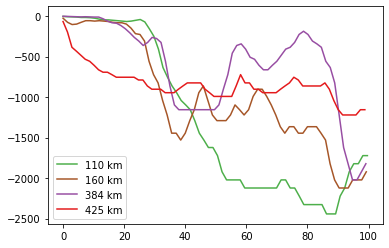

In [12]:
markers=Line2D.filled_markers
markers=np.delete(markers,np.arange(2,5,1))
colors=[ '#4daf4a', '#a65628', '#984ea3',
                   '#e41a1c']

fig,ax = plt.subplots()
for i in np.arange(0,4,1):
    ax.plot(distcross[i,depcross[i,:]!=0],-depcross[i,depcross[i,:]!=0], label=f'{dist[hej[i]]:.0f} km', color=colors[i])
ax.legend()

In [13]:
params = {'font.size': 18,
          'figure.figsize': (15, 6),
         'font.family':'sans'}
pl.rcParams.update(params)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

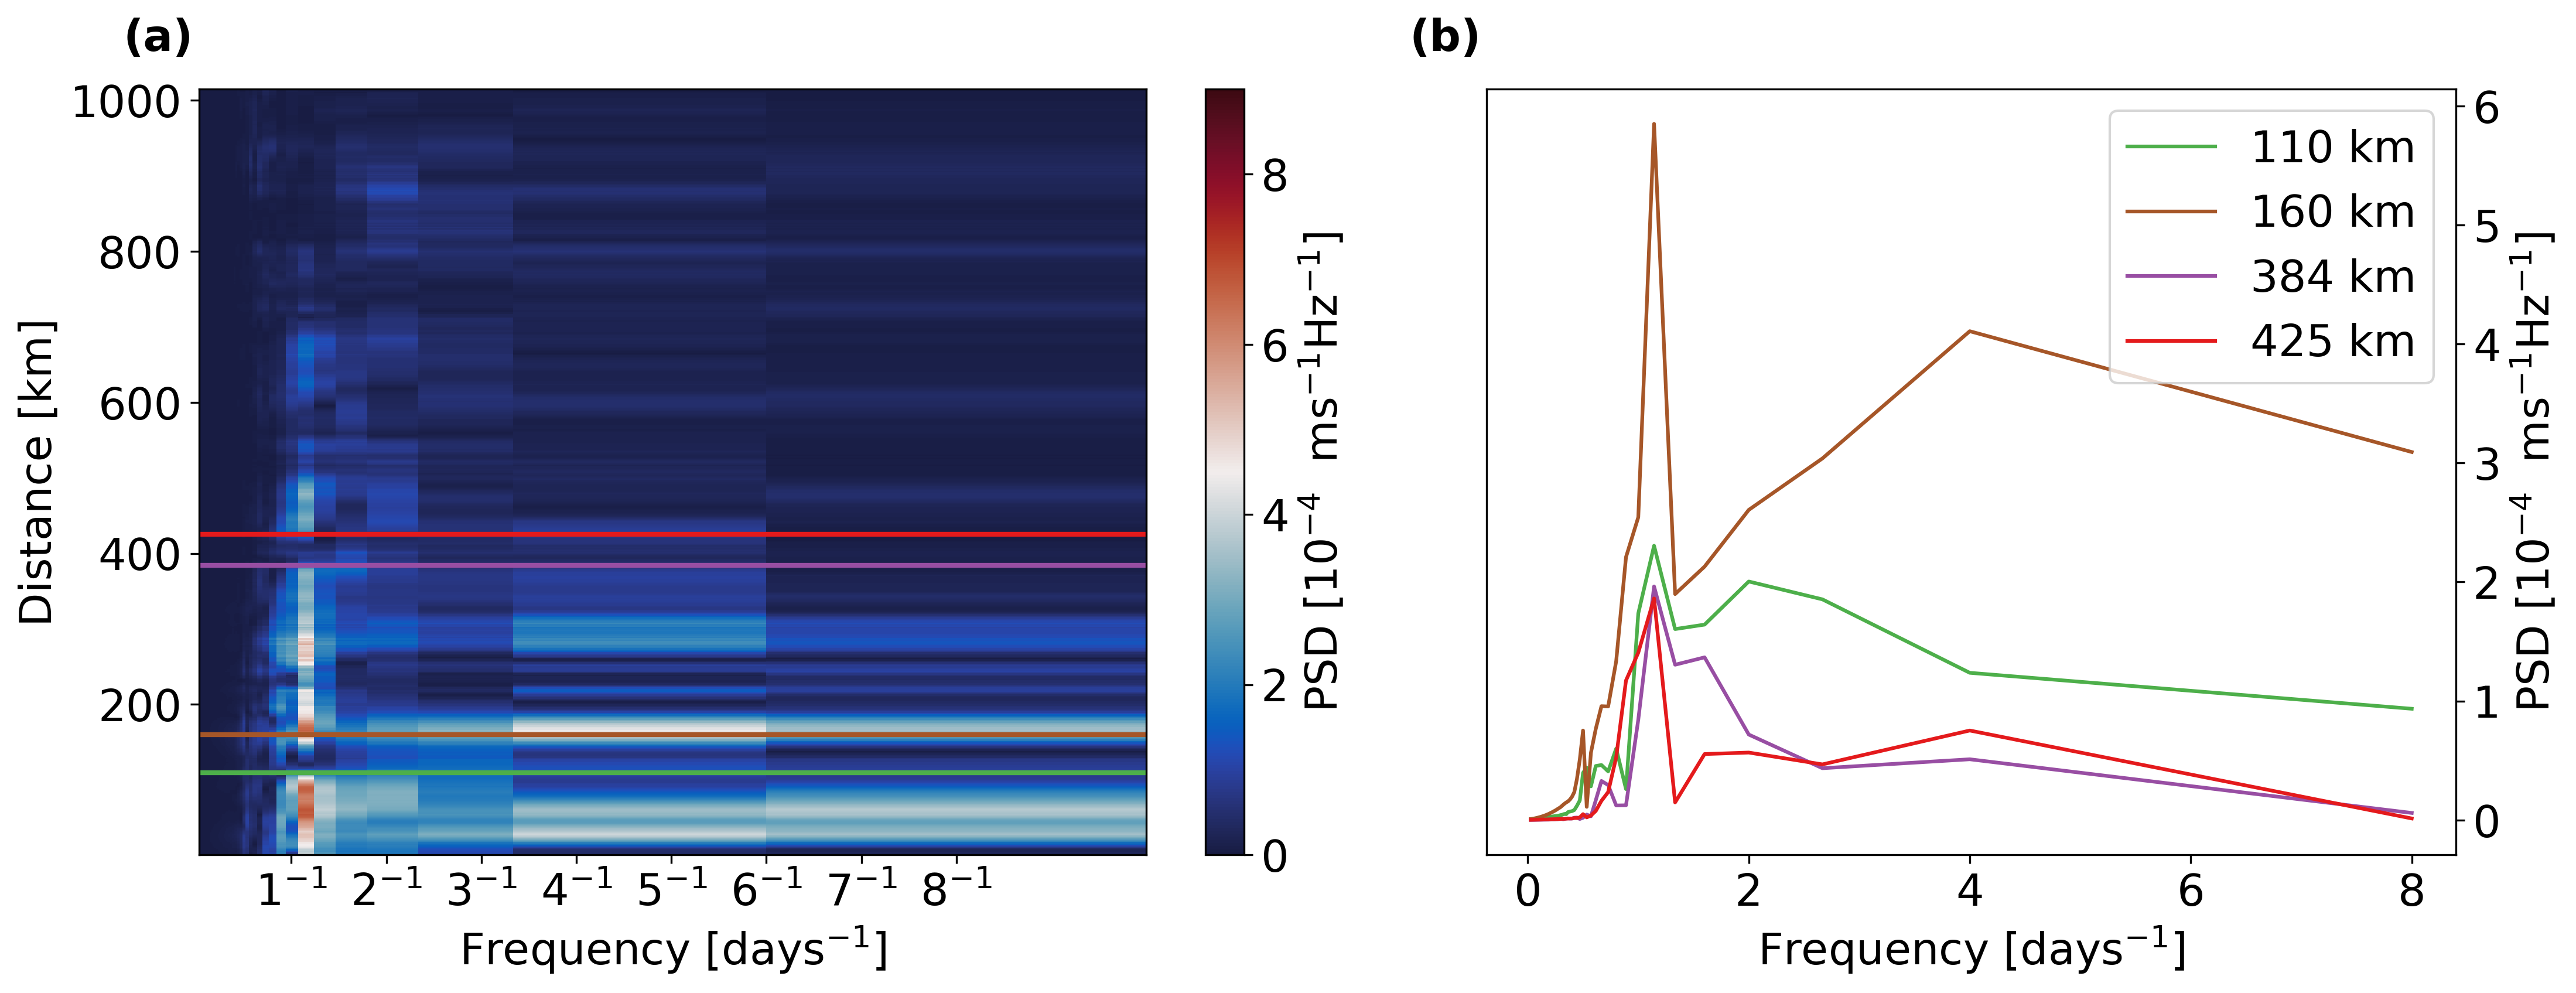

In [14]:
fig = plt.figure()
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1.1, 0.9])


vmin=0
vmax=9
psdplot=np.transpose(psd[:,1:])
title='PSD [$10^{-4}$  ms$^{-1}$Hz$^{-1}$]'
xlab='Frequency [days$^{-1}$]'
ylab='Distance [km]'

#time= TIME.values.astype(int)
#time=dat.date2num(TIME)
markers=Line2D.filled_markers
markers=np.delete(markers,np.arange(2,5,1))
colors=[ '#4daf4a', '#a65628', '#984ea3',
                   '#e41a1c']

ax = fig.add_subplot(gs[0, 0])
ax.set(xlabel=xlab, ylabel=ylab)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels(['0$^{-1}$', '1$^{-1}$', '2$^{-1}$', '3$^{-1}$','4$^{-1}$', '5$^{-1}$', '6$^{-1}$', '7$^{-1}$', '8$^{-1}$'])
ax.text(-0.08, 1.05, '(a)', fontweight='bold', color='k', 
        transform=ax.transAxes)
#val=VAL.values
cax = ax.pcolormesh(periodsplotfilt[1,:],dist,psdfilt[:,1:]*1e4,vmin=vmin,vmax=vmax, cmap=cmocean.cm.balance)

cb = plt.colorbar(cax)

cb.set_label(title)

ax1 = fig.add_subplot(gs[0, 1])
p=0
for i in hej:
    p=p+1
    ax.axhline(y=dist[i],color=colors[p-1],linewidth=2)
    ax1.plot(periodsplotfilt[1,:],psdfilt[i,1:]*1e4, label=f'{dist[hej[p-1]]:.0f} km', color=colors[p-1])
ax1.legend()

ax1.set(xlabel=xlab, ylabel=title)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
#ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
#ax1.set_xticklabels(['1/0', '1/1', '1/2', '1/3','1/4', '1/5', '1/6', '1/7', '1/8'])
ax1.text(-0.08, 1.05, '(b)', fontweight='bold', color='k', 
        transform=ax1.transAxes)
fig.tight_layout()


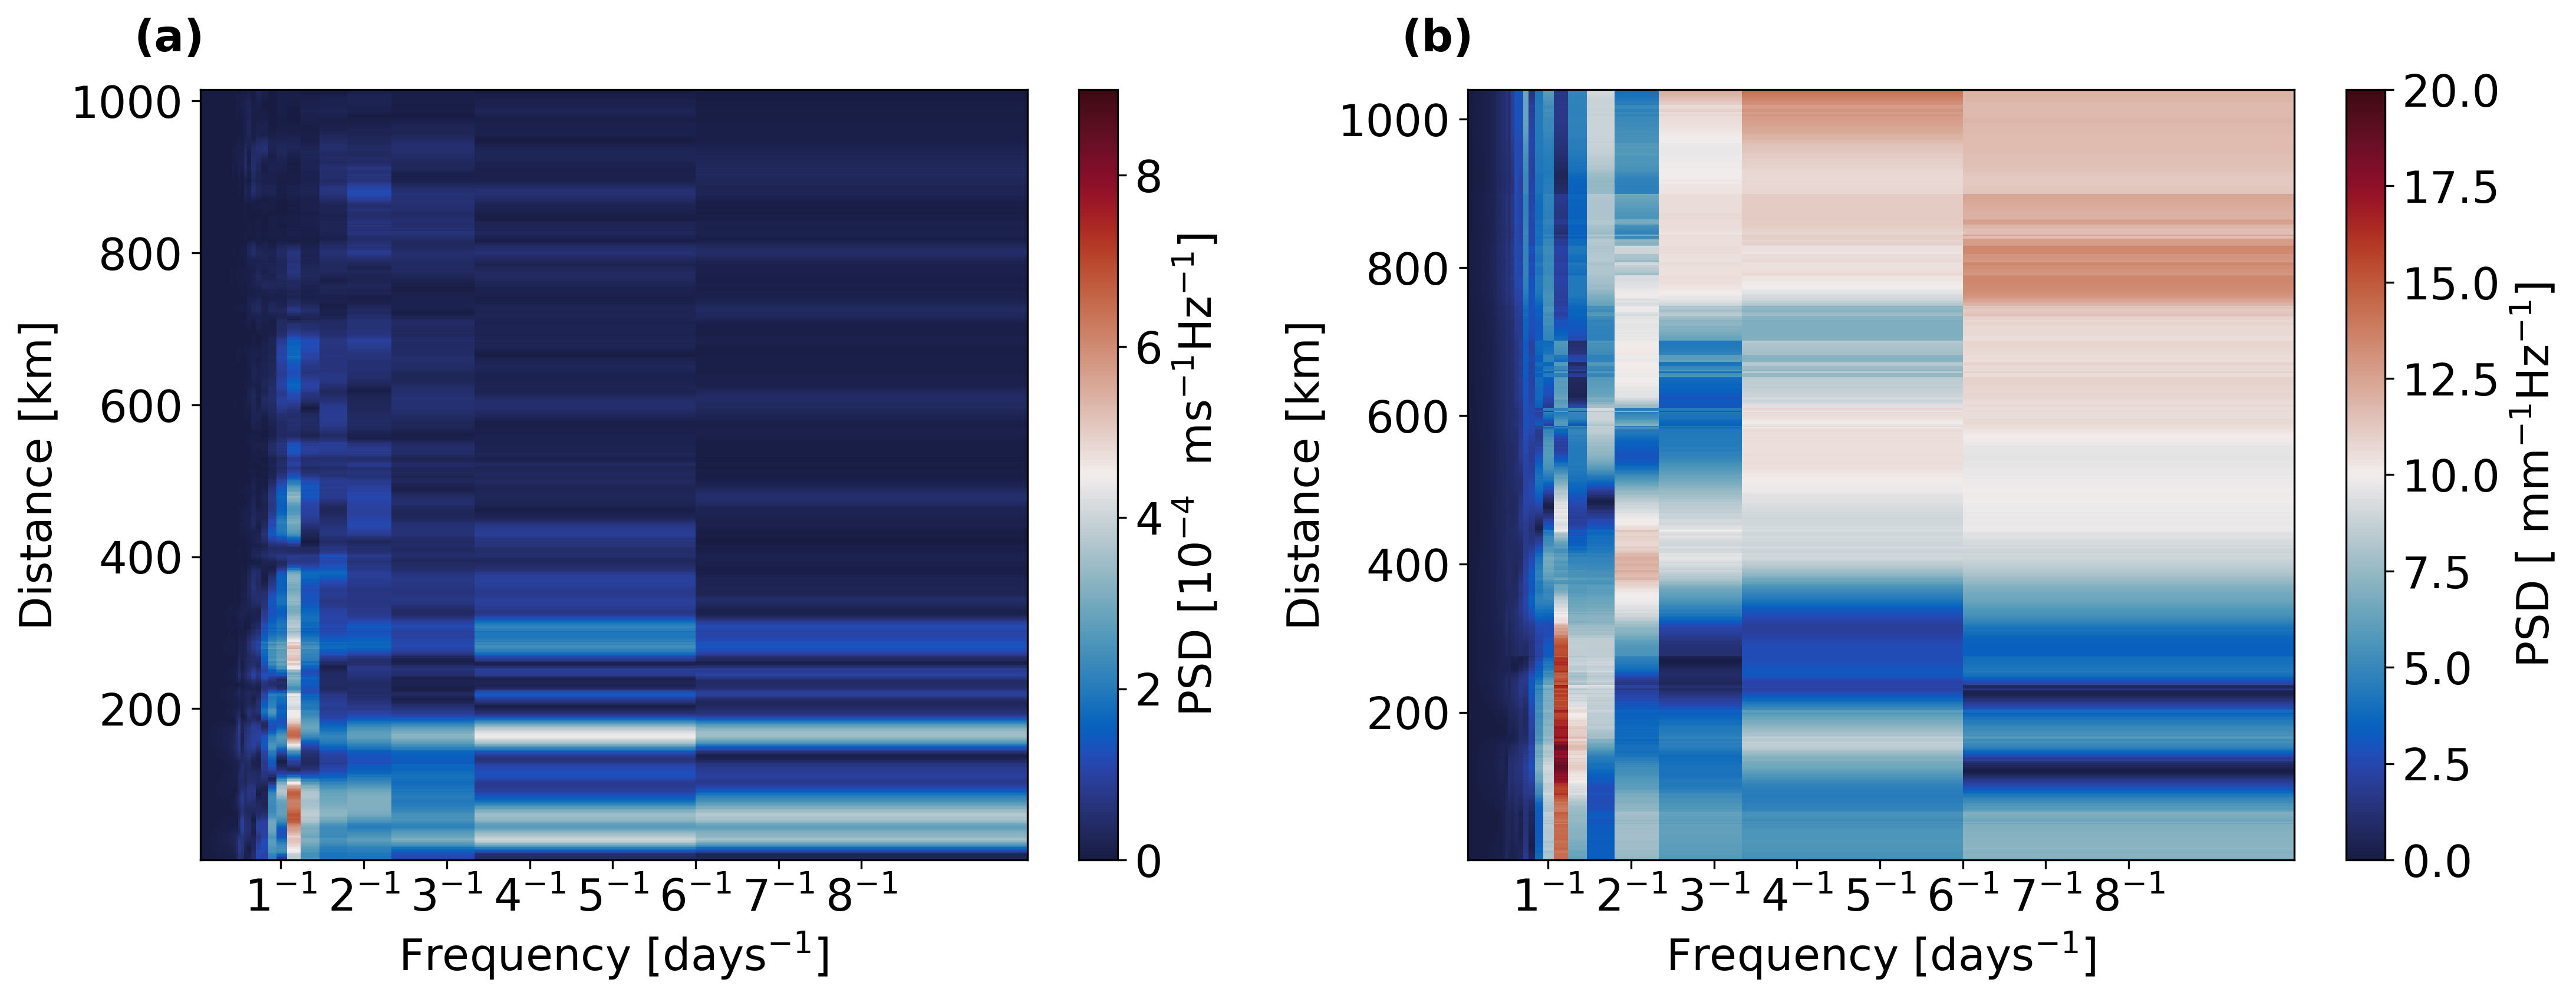

In [15]:
fig = plt.figure()
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])


vmin=0
vmax=9
psdplot=np.transpose(psd[:,1:])
title='PSD [$10^{-4}$  ms$^{-1}$Hz$^{-1}$]'
titleeta='PSD [ mm$^{-1}$Hz$^{-1}$]'
xlab='Frequency [days$^{-1}$]'
ylab='Distance [km]'

#time= TIME.values.astype(int)
#time=dat.date2num(TIME)
markers=Line2D.filled_markers
markers=np.delete(markers,np.arange(2,5,1))
colors=[ '#4daf4a', '#a65628', '#984ea3',
                   '#e41a1c']

ax = fig.add_subplot(gs[0, 0])
ax.set(xlabel=xlab, ylabel=ylab)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels(['0$^{-1}$', '1$^{-1}$', '2$^{-1}$', '3$^{-1}$','4$^{-1}$', '5$^{-1}$', '6$^{-1}$', '7$^{-1}$', '8$^{-1}$'])
ax.text(-0.08, 1.05, '(a)', fontweight='bold', color='k', 
        transform=ax.transAxes)
#val=VAL.values
cax = ax.pcolormesh(periodsplotfilt[1,:],dist,psdfilt[:,1:]*1e4,vmin=vmin,vmax=vmax, cmap=cmocean.cm.balance)

cb = plt.colorbar(cax)

cb.set_label(title)
vmineta=0
vmaxeta=20
ax1 = fig.add_subplot(gs[0, 1])
ax1.set(xlabel=xlab, ylabel=ylab)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels(['0$^{-1}$', '1$^{-1}$', '2$^{-1}$', '3$^{-1}$','4$^{-1}$', '5$^{-1}$', '6$^{-1}$', '7$^{-1}$', '8$^{-1}$'])
ax1.text(-0.08, 1.05, '(b)', fontweight='bold', color='k', 
        transform=ax1.transAxes)
#val=VAL.values
cax = ax1.pcolormesh(periodsplotfilt[1,:],disteta,psdfilteta[:,1:]*1e3,vmin=vmineta,vmax=vmaxeta, cmap=cmocean.cm.balance)

cb = plt.colorbar(cax)

cb.set_label(titleeta)

fig.tight_layout()
